In [1]:
import os, sys
import os.path
import pickle
import numpy as np
import itertools as it

import string

from UQpy.distributions import Normal, Uniform, JointIndependent

sys.path.append('../SPCE/')
from SPCE_optuna import  *
from SPCE_postprocess import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mycolorpy import colorlist as mcp

import proplot as pplt

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.1
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [2]:
if not os.path.exists('plots/SPCE/PT'):
    os.makedirs('plots/SPCE/PT')

In [3]:
def calculate_sensitivity_indices(SPCE_res, joint_x, theta_i):
    
    A  = SPCE_res['x4']
    c_hat = SPCE_res['x5']
    sigma_hat = SPCE_res['x6']

    SI_with_Z = SPCE_first_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                         dist_object_x = joint_x,
                                         multi_index_set = A,
                                         sigma = sigma_hat*np.var(theta_i, ddof=1),
                                         with_Z = True)


    STI_with_Z = SPCE_total_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                          dist_object_x = joint_x,
                                          multi_index_set = A,
                                          sigma = sigma_hat*np.var(theta_i, ddof=1),
                                          with_Z = True)
    
    return SI_with_Z, STI_with_Z


def SI_from_optuna_files(res_files, thetas_list, joint_x, n_params, n_dcoords):

    fo_si_3_thetas = np.zeros((n_params, n_dcoords))
    to_si_3_thetas = np.zeros((n_params, n_dcoords))

    for i, theta in enumerate(thetas_list):

        resilt = np.load(res_files[i], allow_pickle=True)
        SI, STI = calculate_sensitivity_indices(resilt, joint_x, theta)

        fo_si_3_thetas[:, i] = SI.T
        to_si_3_thetas[:, i] = STI.T
        
    return fo_si_3_thetas, to_si_3_thetas

# Input space

In [4]:
num_samples = 1024*5

In [5]:
# input parameters

with open('data/data_SPCE/input_data/3_param_saltelli.pickle', 'rb') as f:
    saltelli_3_param = pickle.load(f)
      
pdf1 = Uniform(loc=0.01, scale=1.99) 
pdf2 = Uniform(loc=0.70, scale=0.10)  
pdf3 = Uniform(loc=0.30, scale=0.15)

margs = [pdf1, pdf2, pdf3]
joint_x = JointIndependent(marginals=margs)

x = saltelli_3_param


In [6]:
PATH = "../SPCE/optuna_verbose/"

# Macro level: 

1. standardised theta
2. scaling the range for sigma with variance of theta

In [7]:
result_nonparsim = np.load(f'data/data_SPCE/GSA_results/GDMaps/PT_macro_nonparsim_onerun_p_4.npz', 
                               allow_pickle=True)

macro_g_nonparsim = result_nonparsim["x4"]

macro_theta_1 = macro_g_nonparsim[:, 0].reshape(num_samples, 1)
macro_theta_2 = macro_g_nonparsim[:, 1].reshape(num_samples, 1)
macro_theta_3 = macro_g_nonparsim[:, 2].reshape(num_samples, 1)

In [8]:
st_g_nonparsim = macro_g_nonparsim/np.std(macro_g_nonparsim, axis=0)

st_theta_1 = st_g_nonparsim[:, 0].reshape(num_samples, 1)
st_theta_2 = st_g_nonparsim[:, 1].reshape(num_samples, 1)
st_theta_3 = st_g_nonparsim[:, 2].reshape(num_samples, 1)

In [9]:
# example how run

# PT_3_param_SPCE_st_theta_1_st = StochasticPCE(X = x, 
#                                               y = st_theta_1, 
#                                               dist_obj = joint_x,
#                                               D = ["Uniform", "Normal"], 
#                                               p_values = [3, 4, 5],
#                                               q_values = [0.5, 0.75, 1],
#                                               scale_e_LOO = 1,
#                                               sim_name = "PT_3_param_st_theta_1_U_N_p3_p5").fit_adaptively()

## Theta1 standardised

Normal:

`PT_3_param_st_theta_1_only_N_p3_p5`


Overall best is Normal, p=4, q=0.75


## Theta2 standardised

iPad

`PT_3_param_st_theta_2_only_N_p3_p5`

Normal
- p=3, q=0.5: -2395.7518070977053
- p=3, q=0.75: -2399.2927992857067
- p=3, q=1: did not run


- p=4, q=0.5: -2397.404926451926
- p=4, q=0.75: -2377.8776446136903


`PT_3_param_st_theta_2_only_N_p_4_q_1`
- p=4, q=1: -2378.35928513

`PT_3_param_st_theta_2_only_N_p5_q05_075`
- p=5, q=0.5: -2396.5150980565504

`PT_3_param_st_theta_2_only_N_p5_q075`
- **p=5, q=0.75: -2364.591446076596**

`PT_3_param_st_theta_2_only_N_p_5_q_1`
- p=5, q=1: -2418.26958675

Overall best is Normal, p=5, q=0.75

## Theta3 standardised

Normal:

`PT_3_param_st_theta_3_only_N_p3_p5`

- p=3, q=0.5: -2380.1374604094635
- *p=3, q=0.75: -2379.2413062080377*
- p=3, q=1: -2380.1903579352092


- *p=4, q=0.5: -2368.4279935985724*
- p=4, q=0.75: -2369.068334938068
- p=4, q=1: did not run!


- **p=5, q=0.5: -2368.4149904586616**
- p=5, q=0.75: -2373.6502092837122
- p=5, q=1: -2427.762735375377


Overall best is Normal, p=5, q=0.5

In [10]:
micro_4_st = [PATH+f'PT_3_param_st_theta_1_only_N_p3_p5/inter_res_D_Normal_p_4_q_0.75.npz',
              PATH+f'PT_3_param_st_theta_2_only_N_p5_q075/inter_res_D_Normal_p_5_q_0.75.npz',
              PATH+f'PT_3_param_st_theta_3_only_N_p3_p5/inter_res_D_Normal_p_5_q_0.5.npz']

SI_macro_4_st, STI_macro_4_st = SI_from_optuna_files(res_files = micro_4_st, 
                                                     thetas_list = [st_theta_1, st_theta_2, st_theta_3], 
                                                     joint_x = joint_x,
                                                     n_params=x.shape[1]+1, 
                                                     n_dcoords=3)

## Theta1 with scaling the range for sigma with variance of theta1

`PT_3_param_theta_1_only_N_p3_p5_scaled`

Best from the adaptive algorithm: Normal, p=3, q=1


## Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_theta_2_U_N_p3_p4_scaled`

Uniform:
- p=3, q=0.5: 35499.831384446035
- p=3, q=0.75: 35613.496455853514
- p=3, q=1: 35584.96829645284

- p=4, q=0.5: 35642.376162261
- **p=4, q=0.75: 35643.509359372736**
- p=4, q=1: 35605.587081438425


Normal:
- p=3, q=0.5: 36774.14183582452
- p=3, q=0.75: 36655.76344628612
- p=3, q=1: not run!

- p=4, q=0.5: 36656.13881908594
- **p=4, q=0.75: 36825.43592638198**
- p=4, q=1: 36745.97750319743 


p=5:

`PT_3_param_theta_2_U_N_p5_scaled`

Uniform:
- p=5, q=0.5: 35644.07126028021
- **p=5, q=0.75: 35656.13857093854**
- p=5, q=1: 35598.36221036238

Normal:
- p=5, q=0.5: 36656.128138059925
- **p=5, q=0.75: 36739.50417086715**
- p=5, q=1: 36665.68520178076


Overall best is Normal, p=4, q=0.75

Combine `PT_3_param_theta_2_U_N_p3_p4_scaled` and `PT_3_param_theta_2_U_N_p5_scaled` into `PT_3_param_theta_2_U_N_p3_p5_scaled`


## Theta3 with scaling the range for sigma with variance of theta3


`PT_3_param_theta_3_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 36883.791526766014
- p=3, q=0.75: 36887.85365013998
- p=3, q=1: 37050.266369141835

- p=4, q=0.5: 36899.30089582928
- **p=4, q=0.75: 37051.0089352222**
- p=4, q=1: 36894.95697097131

- p=5, q=0.5: 36889.65365762201
- p=5, q=0.75: 36924.109901540985


`PT_3_param_theta_3_only_N_p_5_q_1_scaled`

- p=5, q=1: 36899.49846828

Overall best is Normal, p=4, q=0.75

In [11]:
micro_4_scaled = [PATH+f'PT_3_param_theta_1_only_N_p3_p5_scaled/inter_res_D_Normal_p_3_q_1.npz',
                  PATH+f'PT_3_param_theta_2_U_N_p3_p4_scaled/inter_res_D_Normal_p_4_q_0.75.npz',
                  PATH+f'PT_3_param_theta_3_only_N_p3_p5_scaled/inter_res_D_Normal_p_4_q_0.75.npz']

SI_macro_4_scaled, STI_macro_4_scaled = SI_from_optuna_files(res_files = micro_4_scaled, 
                                                             thetas_list = [macro_theta_1, 
                                                                            macro_theta_2,
                                                                            macro_theta_3], 
                                                             joint_x = joint_x,
                                                             n_params=x.shape[1]+1, 
                                                             n_dcoords=3)

# Meso level (only scaled ranges for thetas)

p=35

## Meso-35 Theta1 with scaling the range for sigma with variance of theta1

`PT_3_param_meso_35_theta_1_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 45420.774136789754
- p=3, q=0.75: 45483.78801532663
- p=3, q=1: 45610.55190518743

- p=4, q=0.5: 45482.95952347431
- p=4, q=0.75: 45613.4046526865
- p=4, q=1: 45646.207323488656

- p=5, q=0.5: 45485.51884719992
- p=5, q=0.75: 45646.28658916865
- p=5, q=1: 45645.32985995784

Best overall: Normal, p=5, q=0.75



## Meso-35 Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_meso_35_theta_2_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 48992.62063737991
- p=3, q=0.75: 49015.942158069374
- p=3, q=1: 49057.36653734317

- p=4, q=0.5: 49028.02377475404
- p=4, q=0.75: 49056.61515765713
- p=4, q=1: 49073.79525020444

- p=5, q=0.5: 49017.78625722631
- p=5, q=0.75: 49080.529536009955
- p=5, q=1: 49077.29045475638

Best overall: Normal, p=5, q=0.75



## Meso-35 Theta3 with scaling the range for sigma with variance of theta3

`PT_3_param_meso_35_theta_3_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 48989.62126368984
- p=3, q=0.75: 49083.11498035839
- p=3, q=1: 49043.61866272235

- p=4, q=0.5: 49008.55493780369
- p=4, q=0.75: 49023.63918338075
- p=4, q=1: 49029.30034620184

- p=5: did not run

Best overall: Normal, p=3, q=0.75

In [12]:
result_nonparsim = np.load(f'data/data_SPCE/GSA_results/GDMaps/PT_meso_nonparsim_onerun_p_35.npz', 
                               allow_pickle=True)

meso_g_nonparsim = result_nonparsim["x4"]

meso_theta_1 = meso_g_nonparsim[:, 0].reshape(num_samples, 1)
meso_theta_2 = meso_g_nonparsim[:, 1].reshape(num_samples, 1)
meso_theta_3 = meso_g_nonparsim[:, 2].reshape(num_samples, 1)

In [13]:
meso_35_scaled = [PATH+f'PT_3_param_meso_35_theta_1_only_N_p3_p5_scaled/inter_res_D_Normal_p_5_q_0.75.npz',
                  PATH+f'PT_3_param_meso_35_theta_2_only_N_p3_p5_scaled/inter_res_D_Normal_p_5_q_0.75.npz',
                  PATH+f'PT_3_param_meso_35_theta_3_only_N_p3_p5_scaled/inter_res_D_Normal_p_3_q_0.75.npz']

SI_meso_35_scaled, STI_meso_35_scaled = SI_from_optuna_files(res_files = meso_35_scaled, 
                                                             thetas_list = [meso_theta_1, 
                                                                            meso_theta_2,
                                                                            meso_theta_3], 
                                                             joint_x = joint_x,
                                                             n_params=x.shape[1]+1, 
                                                             n_dcoords=3)

# Micro level (only scaled ranges for thetas)

p=95

## Micro-95 Theta1 with scaling the range for sigma with variance of theta1

`PT_3_param_micro_95_theta_1_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 38479.69873218128
- p=3, q=0.75: 39354.89424120572

- p=4, q=0.5: 39358.70259561527
- p=4, q=0.75: 39535.88148213489

(p=5 were terminated)


`PT_3_param_micro_95_theta_1_only_N_p5_q_05_q075_scale`

Normal:
- p=5, q=0.5: 39340.97120143965
- p=5, q=0.75: 39413.35914285794


Combine: `PT_3_param_micro_95_theta_1_only_N_p3_p5_q_05_q075_scaled` + `PT_3_param_micro_95_theta_1_only_N_p5_q_05_q075_scale`


`PT_3_param_micro_95_theta_1_only_N_p3_p5_q1_scaled`

Normal:
- *p=3, q=1: 39578.336625918295*
- p=4, q=1: 39503.017527913275
- p=5, q=1: no need? (still running)

Best overall Normal, p=3, q=1


## Micro-95 Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_micro_95_theta_2_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 44587.718402444385
- p=3, q=0.75: 45086.48698855459

- p=4, q=0.5: 45121.10930819564
- p=4, q=0.75: 45153.54591287776

- p=5, q=0.5: 45114.64901779157
- p=5, q=0.75: 45223.72984245453


`PT_3_param_micro_95_theta_2_only_N_p3_p5_q1_scaled`

Normal:
- p=3, q=1: 45150.823635745284
- **p=4, q=1: 45489.305328231676**
- p=5, q=1: 45295.29285612729

Best overall Normal, p=4, q=1



## Micro-95 Theta3 with scaling the range for sigma with variance of theta3

`PT_3_param_micro_95_theta_3_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 47421.66347048273
- p=3, q=0.75: 47495.84242293473

- p=4, q=0.5: 47534.82134566488
- p=4, q=0.75: 47847.45987775563

- p=5, q=0.5: 47547.52779152598
- p=5, q=0.75: 47877.083762028306


`PT_3_param_micro_95_theta_3_only_N_p3_p5_q1_scaled`

Normal:
- p=3, q=1: 47791.370092558645
- p=4, q=1: 47907.675252396555
- **p=5, q=1: 48018.690637219814**

Best overall: Normal, p=5, q=1

In [14]:
result_nonparsim = np.load(f'data/data_SPCE/GSA_results/GDMaps/PT_micro_nonparsim_onerun_p_95.npz', 
                               allow_pickle=True)

micro_g_nonparsim = result_nonparsim["x4"]

micro_theta_1 = micro_g_nonparsim[:, 0].reshape(num_samples, 1)
micro_theta_2 = micro_g_nonparsim[:, 1].reshape(num_samples, 1)
micro_theta_3 = micro_g_nonparsim[:, 2].reshape(num_samples, 1)

In [15]:
micro_95_scaled = [PATH+f'PT_3_param_micro_95_theta_1_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_3_q_1.npz',
                   PATH+f'PT_3_param_micro_95_theta_2_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_4_q_1.npz',
                   PATH+f'PT_3_param_micro_95_theta_3_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_5_q_1.npz']

SI_micro_95_scaled, STI_micro_95_scaled = SI_from_optuna_files(res_files = micro_95_scaled, 
                                                               thetas_list = [micro_theta_1, 
                                                                              micro_theta_2,
                                                                              micro_theta_3], 
                                                               joint_x = joint_x,
                                                               n_params=x.shape[1]+1, 
                                                               n_dcoords=3)

# Plotting all results (micro, meso, macro)

In [16]:
def plot_SPCE_SIs_all_levels(SIs, figsize, subplot_titles, legend_space, title, suptitle=None):
    
    param_names = [r"$COST$",r"$\beta$", r"$\ell$", r"$Z$"]
    theta_labels = [r"First $\theta$", r"Second $\theta$", r"Third $\theta$"]
    colors = [u'#1f77b4', u'#2ca02c', u'#d62728', "dimgray"]
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    n_rows = int(len(SIs)/2)

    fig, axs = pplt.subplots(ncols=2, nrows=n_rows, figsize=figsize, sharex=True, sharey=True)

    for j, si in enumerate(SIs):
        for i, param in enumerate(param_names):

            axs[j].scatter([1,2,3], si[i], label=param,
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=80, linewidth=0.4, zorder=3)
            axs[j].set_title(subplot_titles[j])
            axs[j].plot([1,2,3], si[i], color=colors[i], linestyle='--')
            
    for ax in axs:
        ax.set_xlim(0.9, 3.1)
        ax.set_ylim(-0.05, 1.05)
      
    ticks = [1,2,3]
    axs.set_xticks(ticks, [r"$\mathbf{\theta}_1$", 
                           r"$\mathbf{\theta}_2$",
                           r"$\mathbf{\theta}_3$"])
    
    for i, ax in enumerate(axs):
        ax.format(abc='(a)',
                 suptitle=suptitle)
        ax.format(rc_kw={'suptitle.size': 20,
                         'suptitle.pad': 8.0,
                         'title.size': 20,
                         'title.pad': 10,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 20,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
        
    lgnd = fig.legend(param_names, ncols=4, frame=False, loc='t',
                       fontsize = 20, bbox_to_anchor=(0.5, legend_space))
    for i in range(len(param_names)):
        lgnd.legendHandles[i]._sizes = [100]
    
    fig.tight_layout()
    plt.savefig(f'plots/SPCE/PT/' + title, bbox_inches='tight')
    plt.show()  


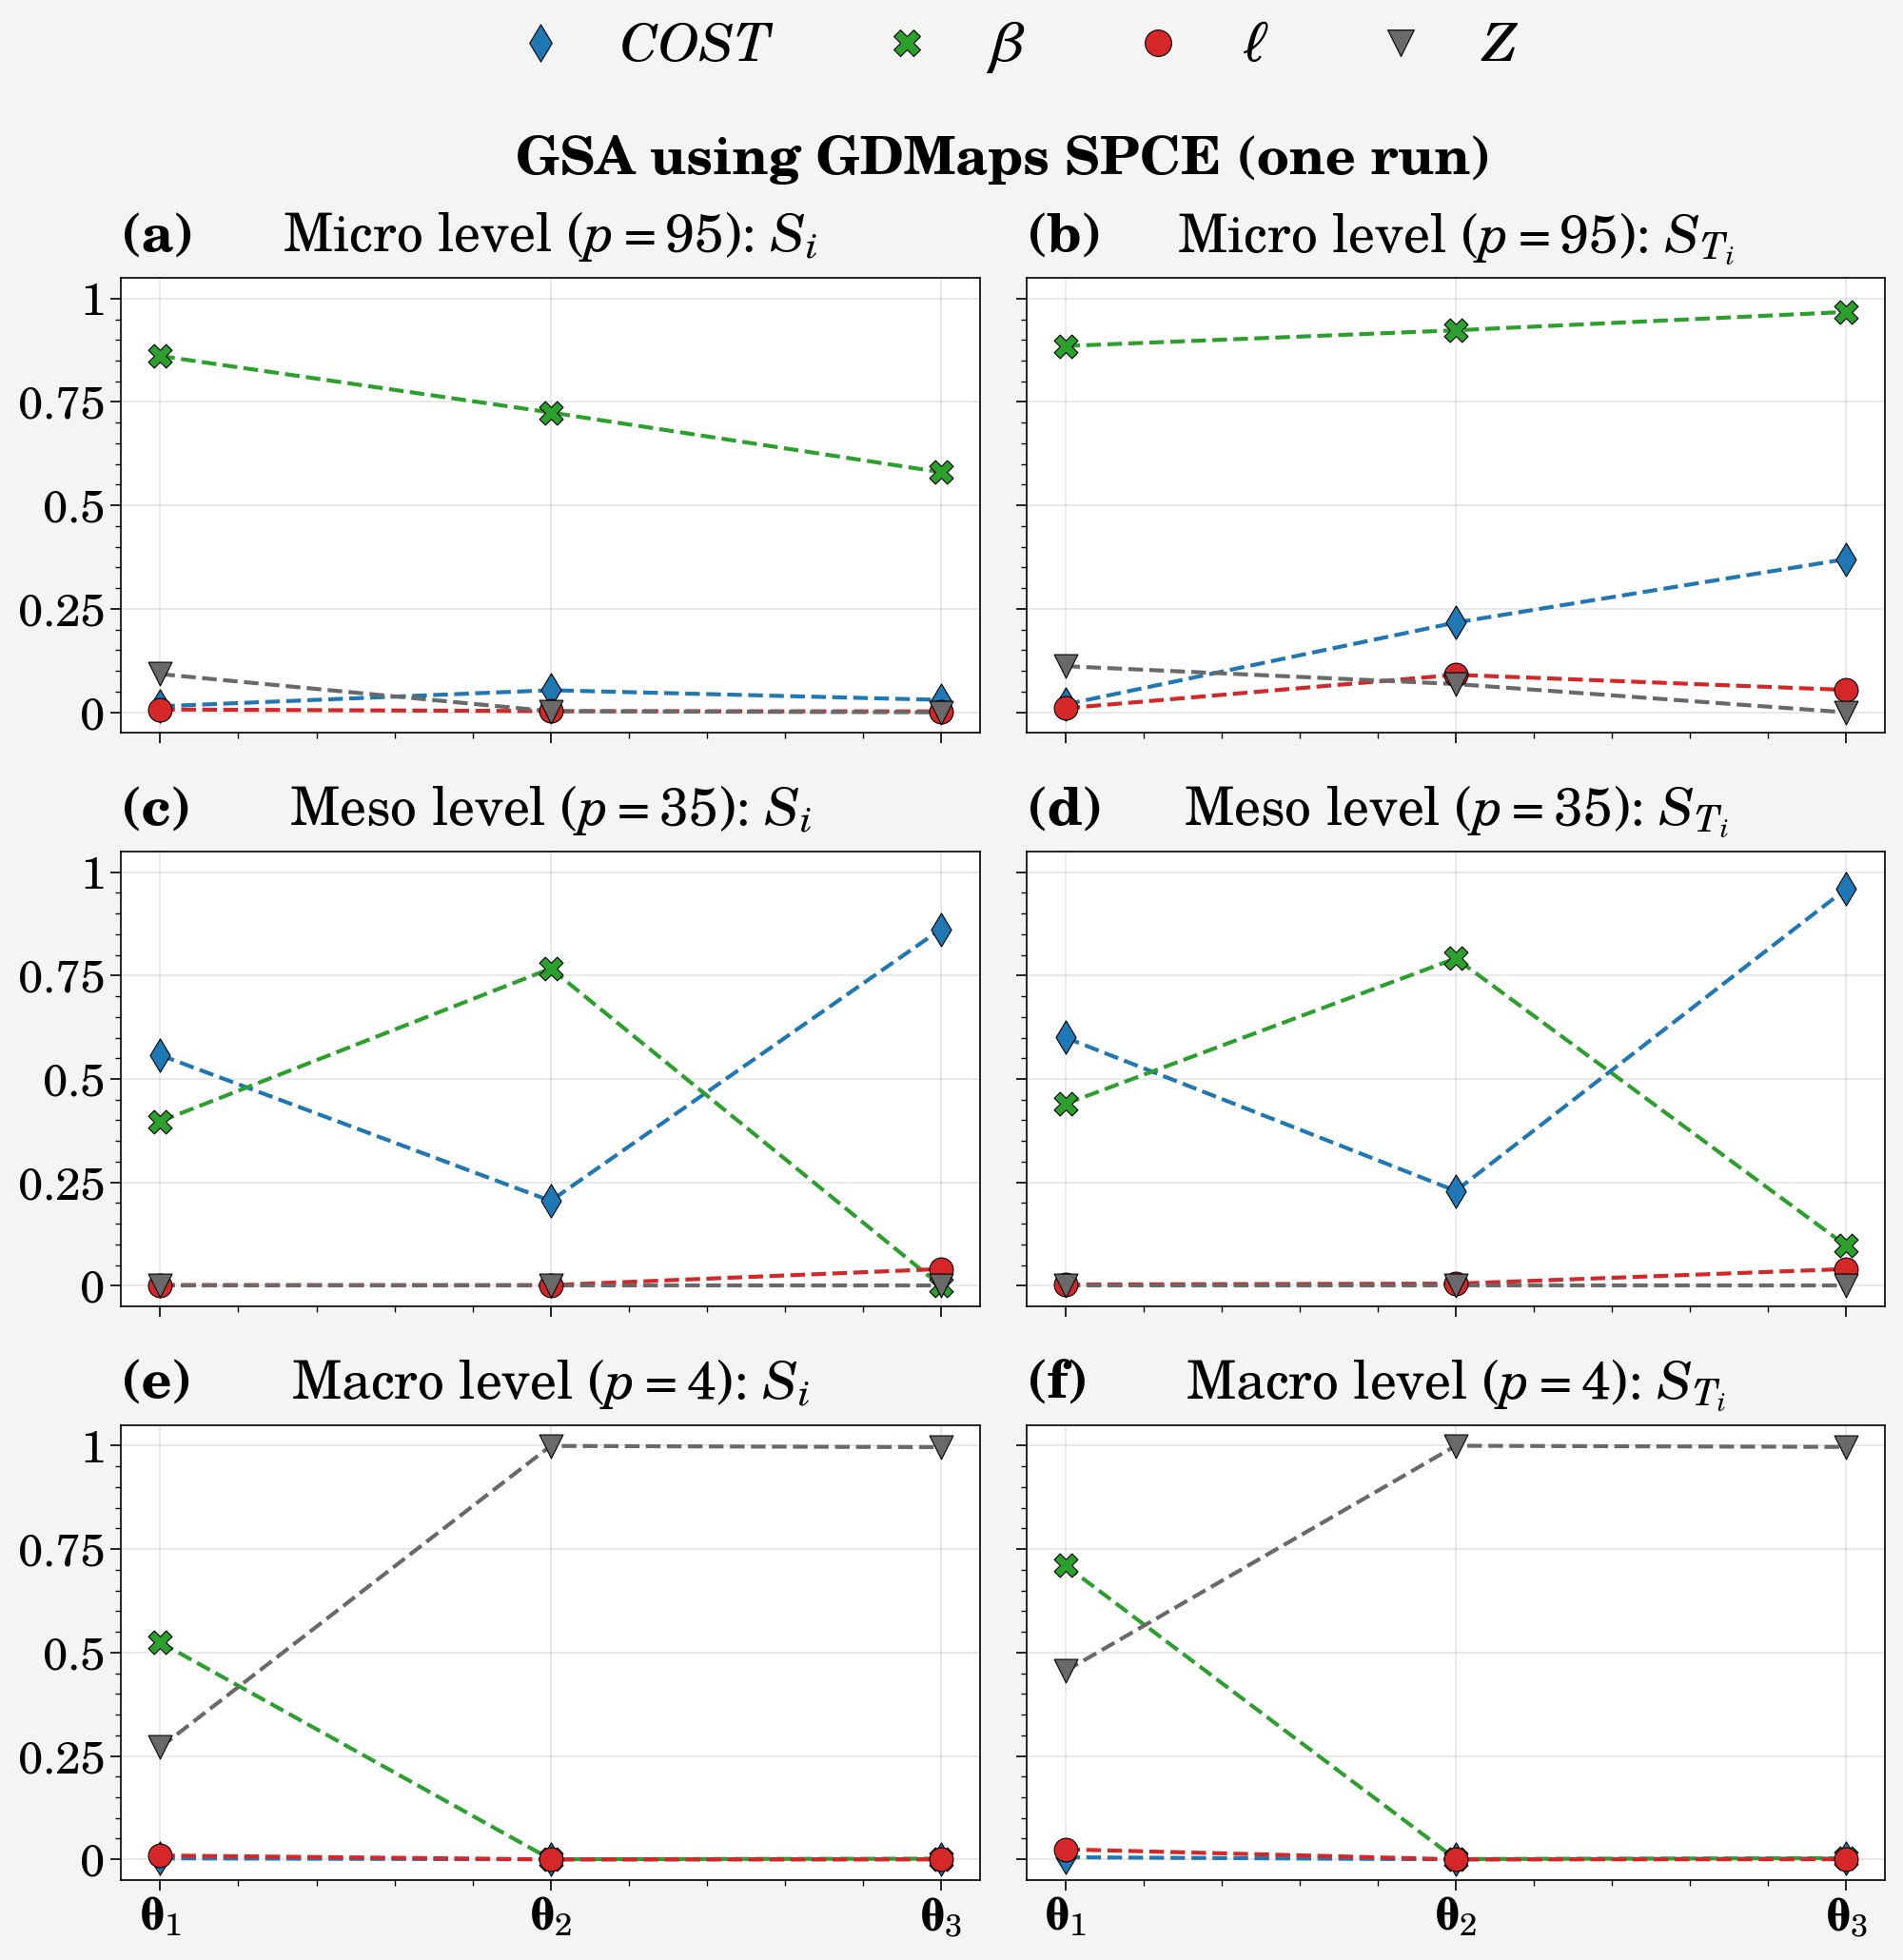

In [17]:
plot_SPCE_SIs_all_levels(SIs = [SI_micro_95_scaled, STI_micro_95_scaled,
                                SI_meso_35_scaled, STI_meso_35_scaled,
                                SI_macro_4_scaled, STI_macro_4_scaled],
                         subplot_titles = [r'Micro level $({p=95})$: $S_{i}$',
                                           r'Micro level $({p=95})$: $S_{T_i}$',
                                           r'Meso level $({p=35})$: $S_{i}$',
                                           r'Meso level $({p=35})$: $S_{T_i}$',
                                           r'Macro level $({p=4})$: $S_{i}$',
                                           r'Macro level $({p=4})$: $S_{T_i}$'],
                         suptitle = "GSA using GDMaps SPCE (one run)",
                         legend_space=2.5,
                         figsize=(10, 10.3),
                         title = "PT3_GSA_SPCE_scaled.pdf")

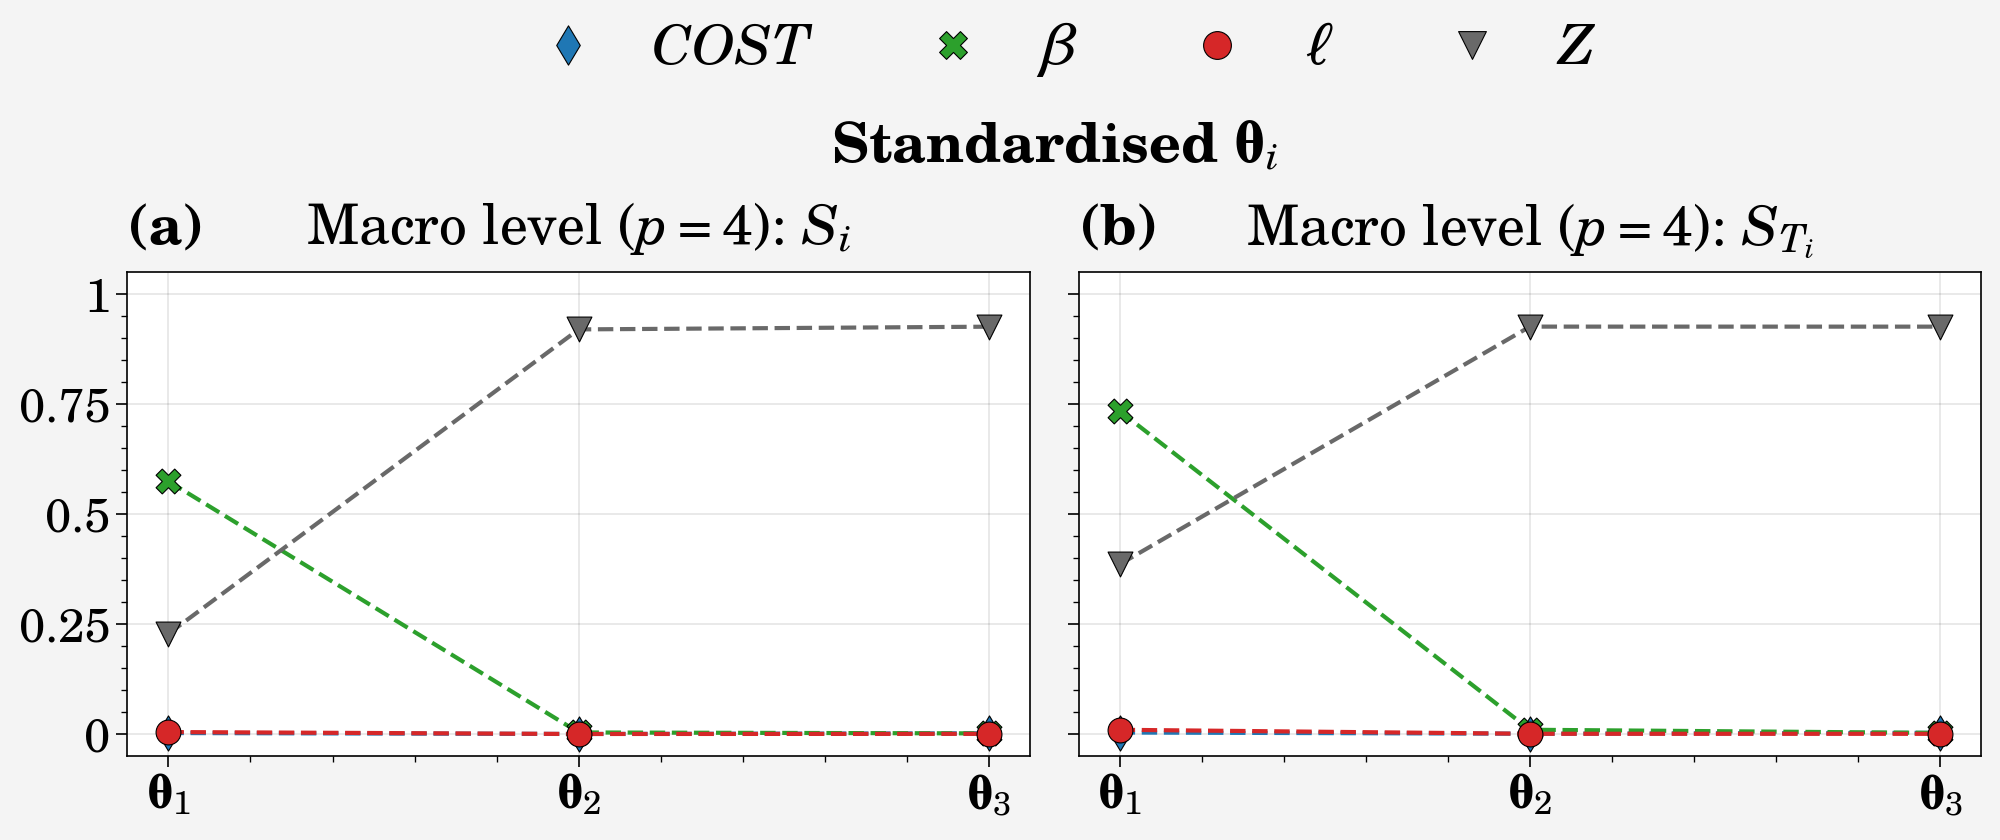

In [18]:
plot_SPCE_SIs_all_levels(SIs = [SI_macro_4_st, STI_macro_4_st],
                         subplot_titles = [r'Macro level $({p=4})$: $S_{i}$',
                                           r'Macro level $({p=4})$: $S_{T_i}$'],  
                         suptitle=r'Standardised $\mathbf{\theta}_i$',
                         legend_space=2,
                         figsize=(10,4.2),
                         title = "PT3_GSA_SPCE_stand_theta.pdf")

# Bayesian optimisation plots

In [19]:
def plot_optuna_iters_slice(study_files, figsize, leftlabels, toplabels, title, suptitle=None):
    
    n_rows = int(len(study_files))
    
    fig, axs = pplt.subplots(ncols=2, nrows=n_rows, figsize=figsize, sharex=False, sharey=True)
    
    for row, study_file in enumerate(study_files):
        with open(study_file, 'rb') as f:
            study = pickle.load(f)
            
        study_dict = study.trials_dataframe().to_dict()
        
        axs[row*2].scatter(list(study_dict["number"].values())[:100], 
                           list(study_dict["value"].values())[:100],
                           color="#1b9e77", edgecolor="k",
                           markersize=60, linewidth=0.4, zorder=3)
        axs[row*2].axhline(study.best_value, xmin=0, xmax=120, c='red', 
                         linewidth=2, ls='--', label=r'Best $\hat{\sigma}$', zorder=4)
        axs[row*2].set_xlabel("Trial")
        axs[row*2].set_ylabel("Objective value")
        axs[row*2].legend(fontsize=18, loc="lower right") # bbox_to_anchor=(0.6, 0.9))


        axs[row*2+1].scatter(list(study_dict["params_sigma"].values())[:100], 
                          list(study_dict["value"].values())[:100],
                          color="#1b9e77", edgecolor="k",
                          markersize=60, linewidth=0.4, zorder=3)
        axs[row*2+1].set_xlabel(r"$\hat{\sigma}$")
    
    numbering  = ["(" + i + ")" for i in list(string.ascii_lowercase)]
    for i, ax in enumerate(axs):
        ax.format(title=numbering[i], titleloc='left', 
                  titlepad=5, titleweight='bold')
        ax.format(suptitle=suptitle,
                  leftlabels=leftlabels,
                  toplabels=toplabels)
        ax.format(rc_kw={'suptitle.size': 20,
                         'suptitle.pad': 8.0,
                         'title.size': 20,
                         'title.pad': 10,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 18,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 20,
                         'toplabel.pad': 5.0,
                         'leftlabel.pad': 14.0,
                         'leftlabel.rotation': "horizontal"})
    
    fig.tight_layout()
    plt.savefig(f'plots/SPCE/PT/' + title, bbox_inches='tight')
    plt.show()  

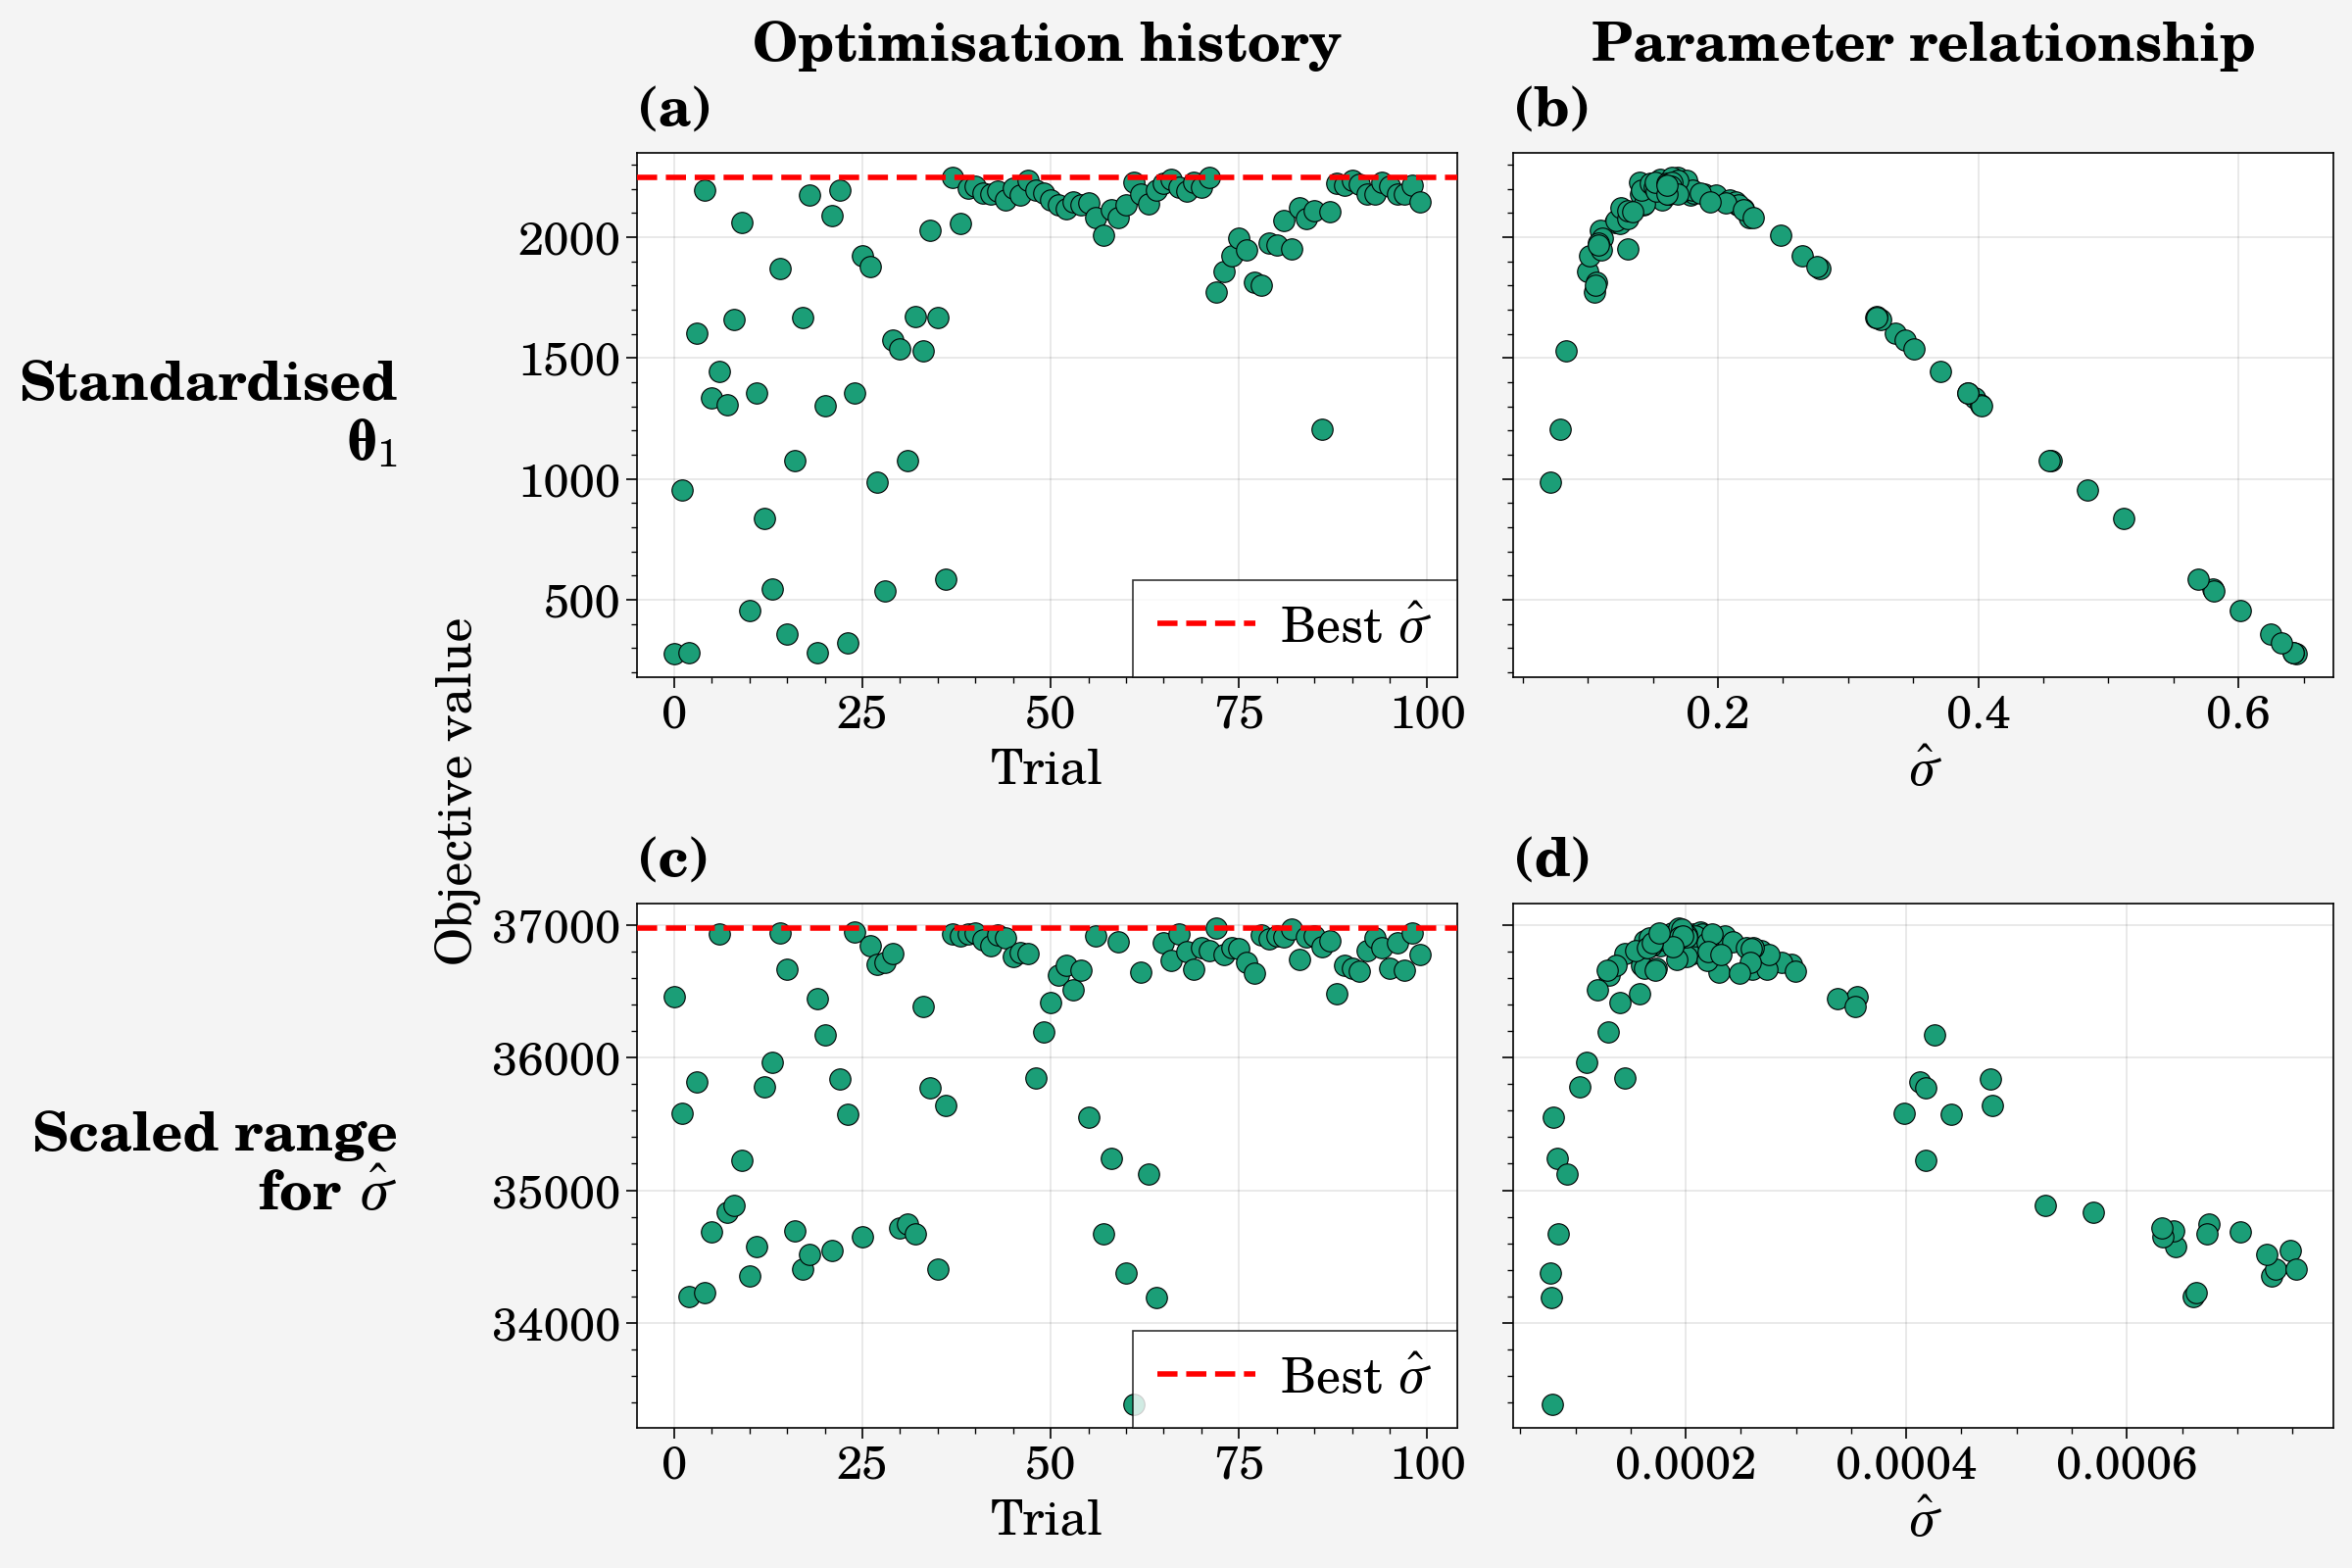

In [20]:
# f'optuna_verbose/PT_3_param_micro_95_theta_1_only_N_p3_p5_q1_scaled/optuna_D_Normal_p_3_q_1.pickle'
# f'optuna_verbose/PT_3_param_meso_35_theta_1_only_N_p3_p5_scaled/optuna_D_Normal_p_5_q_0.75.pickle'


plot_optuna_iters_slice(study_files = [PATH+f'PT_3_param_st_theta_1_only_N_p3_p5/optuna_D_Normal_p_4_q_0.75.pickle',
                                       PATH+f'PT_3_param_theta_1_only_N_p3_p5_scaled/optuna_D_Normal_p_3_q_1.pickle',], 
                        figsize=(12,8),
                        leftlabels = ["Standardised\n" + r"$\mathbf{\theta}_1$",
                                      "Scaled range\n" + r"for $\hat{\sigma}$"],
                        toplabels=("Optimisation history", "Parameter relationship"),
                        title  = "Optuna_verbose.pdf",
                        suptitle=None)

